In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual para gráficos académicos
sns.set_theme(style="whitegrid")

# Cargar tu dataset procesado
# Asegúrate de que el archivo esté en la misma carpeta que tu notebook
df = pd.read_csv('tweets_with_intents.csv')

print(f"Dataset cargado con éxito: {df.shape[0]} tweets y {df.shape[1]} columnas.")
df.head(2) # Vista previa rápida

Dataset cargado con éxito: 158873 tweets y 36 columnas.


,tweetId,tweetUrl,content,isReply,replyTo,createdAt,authorId,authorName,authorUsername,authorVerified,...,unique_word_ratio,avg_word_length,mention_to_word_ratio,clean_content,call to action,attack,mockery,defense,neutral,propaganda
0,1877190873579950336,https://x.com/hectorjalonm/status/187719087357...,@DiegoPonguill10 @DanielNoboaOk @LuisaGonzalez...,True,DiegoPonguill10,2025-01-09 03:09:00,1458536175119986688,héctor 🌵,hectorjalonm,False,...,1.0,16.8,0.6,@DiegoPonguill10 @DanielNoboaOk @LuisaGonzalez...,0.311908,0.293032,0.216954,0.100889,0.042491,0.034726
1,1877188297551650816,https://x.com/DiegoPonguill10/status/187718829...,@hectorjalonm @DanielNoboaOk @LuisaGonzalezEc ...,True,hectorjalonm,2025-01-09 02:59:00,1555549203211976704,Diego Ponguillo Vargas TODO TODITO #5 😉 HLVS!!,DiegoPonguill10,False,...,1.0,7.0,0.2,@hectorjalonm @DanielNoboaOk @LuisaGonzalezEc ...,0.171642,0.250795,0.251195,0.144708,0.084674,0.096985


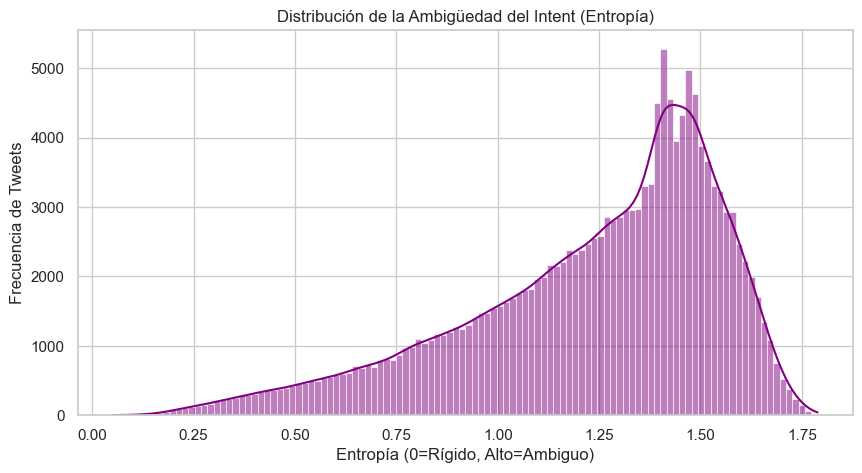

Tweets con MENOR entropía (Más rígidos/posibles bots programados):
                                            clean_content  intent_entropy
4669    @LuisaGonzalezEc Tu dedicación al bienestar de...        0.051033
114516  @LuisaGonzalezEc Este es un llamado claro a la...        0.051854
55180   @LuisaGonzalezEc Que este mensaje nos inspire ...        0.053744


In [3]:
# Definimos las columnas que contienen las probabilidades de los intents
intent_cols = ['call to action', 'attack', 'mockery', 'defense', 'neutral', 'propaganda']

# 1. Cálculo de Entropía de Shannon (H)
# H alto = Alta ambigüedad (Distribución uniforme, el usuario mezcla emociones)
# H bajo = Baja ambigüedad (Pico alto en una sola emoción, comportamiento rígido/fanático)
df['intent_entropy'] = df[intent_cols].apply(entropy, axis=1)

# Visualización Académica: Distribución de la Entropía
plt.figure(figsize=(10, 5))
sns.histplot(df['intent_entropy'], kde=True, color='purple')
plt.title('Distribución de la Ambigüedad del Intent (Entropía)')
plt.xlabel('Entropía (0=Rígido, Alto=Ambiguo)')
plt.ylabel('Frecuencia de Tweets')
plt.show()

# Validamos valores extremos
print("Tweets con MENOR entropía (Más rígidos/posibles bots programados):")
print(df[['clean_content', 'intent_entropy']].nsmallest(3, 'intent_entropy'))

In [7]:
# --- NORMALIZACIÓN DE SEÑALES (Rank Percentiles) ---

# 1. Señal Temporal: Edad de la Cuenta (Inversa: Más joven = Más sospechoso)
df['rank_age'] = 1 - df['account_age_days'].rank(pct=True)

# 2. Señal de Automatización: Tiempo de Respuesta (Inversa: Más rápido = Más sospechoso)
df['rank_speed'] = 1 - df['time_response'].rank(pct=True)

# 3. Señal Estilística: Uso de Mayúsculas (Directa: Más gritos = Más sospechoso)
df['rank_caps'] = df['uppercase_ratio'].rank(pct=True)

# 4. Señal de Spam: Cantidad de Menciones (Directa: Más menciones = Más sospechoso)
df['rank_spam'] = df['mentions_count'].rank(pct=True)

# 5. Señal Cognitiva: Entropía (Tu Tesis)
# Hipótesis: Penalizamos la BAJA entropía (Comportamiento monotemático/robótico)
df['rank_entropy'] = 1 - df['intent_entropy'].rank(pct=True)

# --- SISTEMA DE PESOS (WEIGHTED SCORING) ---
# Estos pesos pueden ajustarse, pero esta es una configuración base sólida
weights = {
    'age': 0.30,      # La antigüedad es un proxy fuerte de legitimidad
    'entropy': 0.25,  # Tu métrica semántica
    'speed': 0.20,    # Velocidad de respuesta
    'caps': 0.15,     # Estilo agresivo
    'spam': 0.10      # Comportamiento de difusión
}

# Cálculo del Score Final (0 a 1)
df['heuristic_bot_score'] = (
    df['rank_age'] * weights['age'] +
    df['rank_entropy'] * weights['entropy'] +
    df['rank_speed'] * weights['speed'] +
    df['rank_caps'] * weights['caps'] +
    df['rank_spam'] * weights['spam']
)

print("Score heurístico calculado.")

Score heurístico calculado.


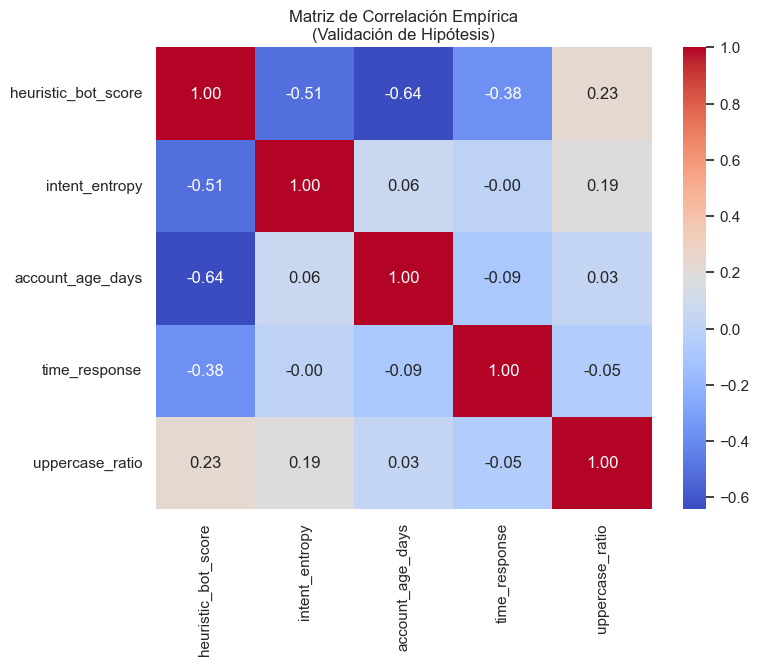

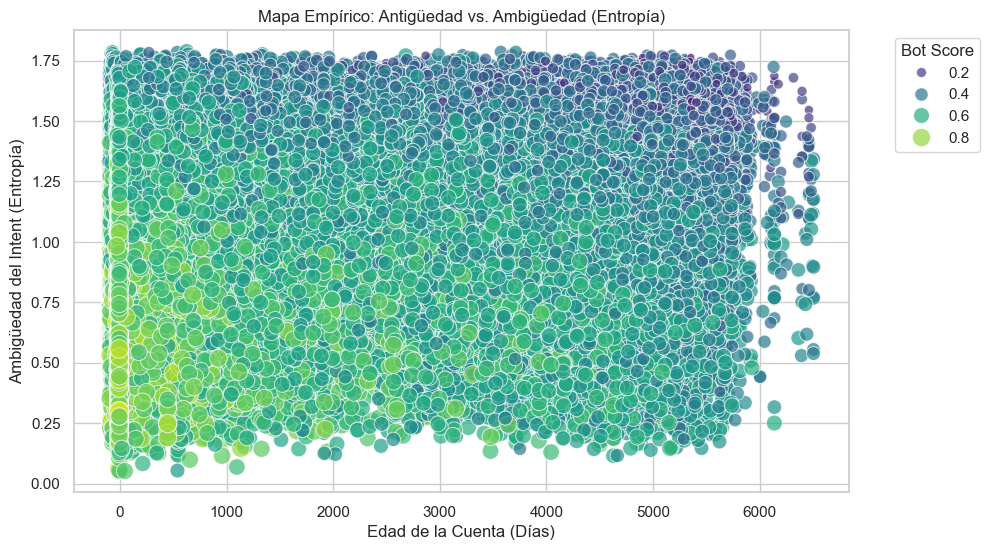

--- INSPECCIÓN EMPÍRICA DE EXTREMOS ---

>>> CASOS DE ALTA SOSPECHA (Top Score):
User: RafaelRafa68528 | Score: 0.95 | Edad: -38d | Texto: @LuisaGonzalezEc @RC5Oficial UNA PUBLICACION PARA ...
User: EcCiudano48 | Score: 0.94 | Edad: 115d | Texto: @LuisaGonzalezEc @DianaAtamaint @SNAI_Ec Si señora...
User: Sagitario1317 | Score: 0.93 | Edad: -2d | Texto: @LuisaGonzalezEc @JaimeEstradaM UNICA Y PERFECTA P...
User: MarioMonzon31 | Score: 0.93 | Edad: -6d | Texto: @LuisaGonzalezEc @BancoMundial @RC5Oficial #YoVoto...
User: ELECCION_X | Score: 0.93 | Edad: -35d | Texto: @LuisaGonzalezEc @RC5Oficial .
Unicamente con VISI...

>>> CASOS DE BAJA SOSPECHA (Humanos Probables):
User: Elpilas4 | Score: 0.04 | Edad: 5355d | Texto: Vi a un hombre que tenía una historia de lucha y p...
User: sophiamabel | Score: 0.05 | Edad: 5545d | Texto: La neta? Anda lávate la jeta. Vienen hechos los mu...
User: FMLAMAO | Score: 0.06 | Edad: 5213d | Texto: @DanielNoboaOk Señor presidente buenas tardes, ust...
User:

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- A. VALIDACIÓN ESTADÍSTICA (Matriz de Correlación) ---
# Queremos demostrar que la Entropía (tu aporte) tiene relación con variables "duras" (Edad, Tiempo).
# Usamos correlación de Spearman porque las variables no necesariamente siguen una distribución normal perfecta.

# Seleccionamos las variables de interés
validation_vars = ['heuristic_bot_score', 'intent_entropy', 'account_age_days', 'time_response', 'uppercase_ratio']
corr_matrix = df[validation_vars].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación Empírica\n(Validación de Hipótesis)')
plt.show()

# Interpretación para la Tesis:
# Si 'heuristic_bot_score' tiene correlación NEGATIVA fuerte con 'account_age_days',
# has probado empíricamente que tu score detecta cuentas nuevas anómalas.

# --- B. VALIDACIÓN VISUAL (Scatter Plot) ---
# Vamos a visualizar si los "Bots" (Score alto) se agrupan en una zona específica
# Eje X: Antigüedad (Dato duro)
# Eje Y: Entropía (Tu métrica semántica)
# Color: Heuristic Score

plt.figure(figsize=(10, 6))
scatterplot = sns.scatterplot(
    data=df,
    x='account_age_days',
    y='intent_entropy',
    hue='heuristic_bot_score',
    palette='viridis',
    size='heuristic_bot_score',
    sizes=(20, 200),
    alpha=0.7
)
plt.title('Mapa Empírico: Antigüedad vs. Ambigüedad (Entropía)')
plt.xlabel('Edad de la Cuenta (Días)')
plt.ylabel('Ambigüedad del Intent (Entropía)')
plt.legend(title='Bot Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- C. MICRO-MUESTREO (Human-in-the-loop) ---
# Imprimimos ejemplos extremos para que TÚ (el humano) valides si el score tiene sentido.
# Esto te permite decir en la tesis: "Se realizó una inspección manual de una muestra aleatoria..."

print("--- INSPECCIÓN EMPÍRICA DE EXTREMOS ---")

print("\n>>> CASOS DE ALTA SOSPECHA (Top Score):")
# Filtramos cuentas con score alto
suspects = df.nlargest(5, 'heuristic_bot_score')
for i, row in suspects.iterrows():
    print(f"User: {row['authorUsername']} | Score: {row['heuristic_bot_score']:.2f} | Edad: {row['account_age_days']}d | Texto: {row['clean_content'][:50]}...")

print("\n>>> CASOS DE BAJA SOSPECHA (Humanos Probables):")
# Filtramos cuentas con score bajo
humans = df.nsmallest(5, 'heuristic_bot_score')
for i, row in humans.iterrows():
    print(f"User: {row['authorUsername']} | Score: {row['heuristic_bot_score']:.2f} | Edad: {row['account_age_days']}d | Texto: {row['clean_content'][:50]}...")

In [9]:
# Definimos el umbral de corte (Thresholding)
# Consideramos el top 25% de scores más altos como "Sospechosos"
threshold = df['heuristic_bot_score'].quantile(0.75)

def assign_label(score):
    if score >= threshold:
        return 1 # Etiqueta 1: BOT_CANDIDATE (Clase Positiva)
    else:
        return 0 # Etiqueta 0: HUMAN_LEANING (Clase Negativa)

df['pseudo_label'] = df['heuristic_bot_score'].apply(assign_label)

# Verificación de proporciones
print(f"Umbral de corte (Score): {threshold:.4f}")
print("\nDistribución de Pseudo-Etiquetas:")
print(df['pseudo_label'].value_counts(normalize=True))

# Guardar este DataFrame enriquecido para no perder el trabajo
df.to_csv('tweets_processed_for_gnn.csv', index=False)
print("Archivo 'tweets_processed_for_gnn.csv' guardado.")

Umbral de corte (Score): 0.5939

Distribución de Pseudo-Etiquetas:
pseudo_label
0    0.749995
1    0.250005
Name: proportion, dtype: float64
Archivo 'tweets_processed_for_gnn.csv' guardado.


In [10]:
# Una GNN necesita saber quién conecta con quién.
# Nodo Origen (Source): El autor del tweet
# Nodo Destino (Target): A quién le responde (replyTo)

# Filtramos solo los que son respuestas y tienen datos válidos
edges = df[df['isReply'] == True][['authorUsername', 'replyTo']].dropna()
edges.columns = ['source', 'target']

print(f"Total de conexiones (aristas) para el grafo: {len(edges)}")
print("Ejemplo de conexiones:")
print(edges.head())

# Nota para la tesis:
# 'df' contiene las CARACTERÍSTICAS DE LOS NODOS (Features: entropía, edad, etc.)
# 'edges' contiene la ESTRUCTURA DEL GRAFO (Topología)
# La GNN combinará ambas.

Total de conexiones (aristas) para el grafo: 158011
Ejemplo de conexiones:
            source           target
0     hectorjalonm  DiegoPonguill10
1  DiegoPonguill10     hectorjalonm
2      ekuador_593  Gregori58965636
3     JRamirez2O24      jdiegol2010
4      jdiegol2010     JRamirez2O24


In [13]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler

# --- CORRECCIÓN BLOQUE 7: Construcción del Grafo ---

# 1. Mapeo de IDs
edges_mapped = edges.copy()
edges_mapped['source_id'] = edges_mapped['source'].map(user_map)
edges_mapped['target_id'] = edges_mapped['target'].map(user_map)

# 2. SELECCIÓN Y LIMPIEZA (Aquí estaba el error)
# Seleccionamos SOLO las columnas numéricas antes de dropna() y astype(int)
edge_index_data = edges_mapped[['source_id', 'target_id']].dropna().astype(int)

# 3. CREACIÓN DE TENSORES
# Transponemos para tener formato [2, num_edges] que pide PyTorch Geometric
edge_index = torch.tensor(edge_index_data.values.T, dtype=torch.long)

# Node Features (X)
feature_cols = ['heuristic_bot_score', 'intent_entropy', 'account_age_days', 'time_response']
scaler = StandardScaler()
# Usamos user_features que creaste en el Bloque 6
x_data = scaler.fit_transform(user_features[feature_cols])
x = torch.tensor(x_data, dtype=torch.float)

# Labels (Y)
y = torch.tensor(user_features['pseudo_label'].values, dtype=torch.long)

# Objeto Grafo
data_graph = Data(x=x, edge_index=edge_index, y=y)

print("✅ Grafo creado correctamente.")
print(f"Nodos: {data_graph.num_nodes}, Aristas: {data_graph.num_edges}")
print(f"Forma de edge_index: {data_graph.edge_index.shape}") # Debe ser [2, N]

✅ Grafo creado correctamente.
Nodos: 42075, Aristas: 155348
Forma de edge_index: torch.Size([2, 155348])


In [15]:
# --- CORRECCIÓN BLOQUE 8: Split de Datos Riguroso ---

torch.manual_seed(42) # Semilla para que sea reproducible en tu tesis

# Generamos un vector aleatorio del tamaño de los nodos
rand_vec = torch.rand(data_graph.num_nodes)

# Definimos las máscaras booleanas
train_mask = rand_vec < 0.70                      # 70% para entrenar
val_mask = (rand_vec >= 0.70) & (rand_vec < 0.85) # 15% para tuning
test_mask = rand_vec >= 0.85                      # 15% para el examen final (Testing)

# Verificamos que no haya superposición (Sanity Check)
print(f"Total Nodos: {data_graph.num_nodes}")
print(f"Train: {train_mask.sum()} | Val: {val_mask.sum()} | Test: {test_mask.sum()}")

# Aseguramos que sumen el total (o casi, por redondeo)
assert train_mask.sum() + val_mask.sum() + test_mask.sum() == data_graph.num_nodes

Total Nodos: 42075
Train: 29423 | Val: 6292 | Test: 6360


Iniciando Tuning de Hiperparámetros...
Probando Config 1: {'hidden': 16, 'lr': 0.01, 'drop': 0.5} ... Val Acc Final: 0.9379
Probando Config 2: {'hidden': 32, 'lr': 0.005, 'drop': 0.3} ... Val Acc Final: 0.9379
Probando Config 3: {'hidden': 64, 'lr': 0.01, 'drop': 0.6} ... Val Acc Final: 0.9394

🏆 MEJOR MODELO: {'hidden': 64, 'lr': 0.01, 'drop': 0.6} con Acc: 0.9394


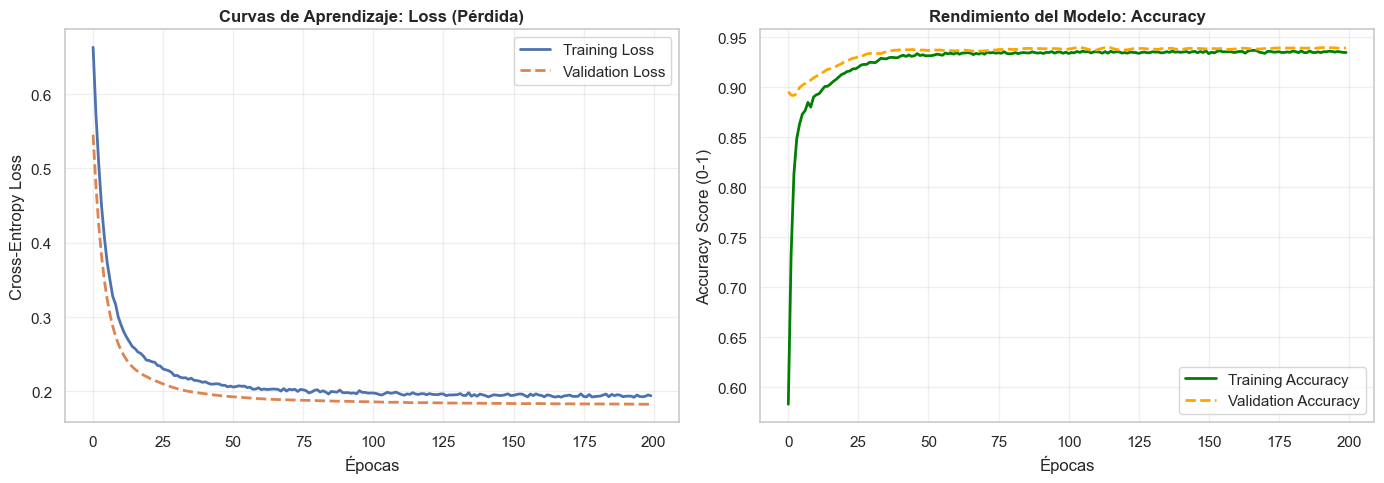

In [16]:
# --- GRID SEARCH SIMPLIFICADO ---
configs = [
    {'hidden': 16, 'lr': 0.01, 'drop': 0.5},  # Configuración A (Estándar)
    {'hidden': 32, 'lr': 0.005, 'drop': 0.3}, # Configuración B (Más compleja, más lenta)
    {'hidden': 64, 'lr': 0.01, 'drop': 0.6}   # Configuración C (Muy compleja)
]

results = []

print("Iniciando Tuning de Hiperparámetros...")
for i, conf in enumerate(configs):
    print(f"Probando Config {i+1}: {conf} ...", end=" ")
    hist, _ = run_experiment(conf['hidden'], conf['lr'], conf['drop'])
    final_val_acc = hist['val_acc'][-1]
    print(f"Val Acc Final: {final_val_acc:.4f}")
    results.append({'conf': conf, 'history': hist, 'val_acc': final_val_acc})

# Seleccionar la mejor configuración
best_run = max(results, key=lambda x: x['val_acc'])
print(f"\n🏆 MEJOR MODELO: {best_run['conf']} con Acc: {best_run['val_acc']:.4f}")

# --- GRAFICAR RESULTADOS (Estilo Académico) ---
history = best_run['history']
epochs_range = range(len(history['train_loss']))

plt.figure(figsize=(14, 5))

# Gráfica 1: Loss (Pérdida)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', linewidth=2)
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
plt.title('Curvas de Aprendizaje: Loss (Pérdida)', fontsize=12, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 2: Accuracy (Precisión)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy', color='green', linewidth=2)
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title('Rendimiento del Modelo: Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Accuracy Score (0-1)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Retraining definitive model with: {'hidden': 64, 'lr': 0.01, 'drop': 0.6}
Starting training loop...
Training completed.


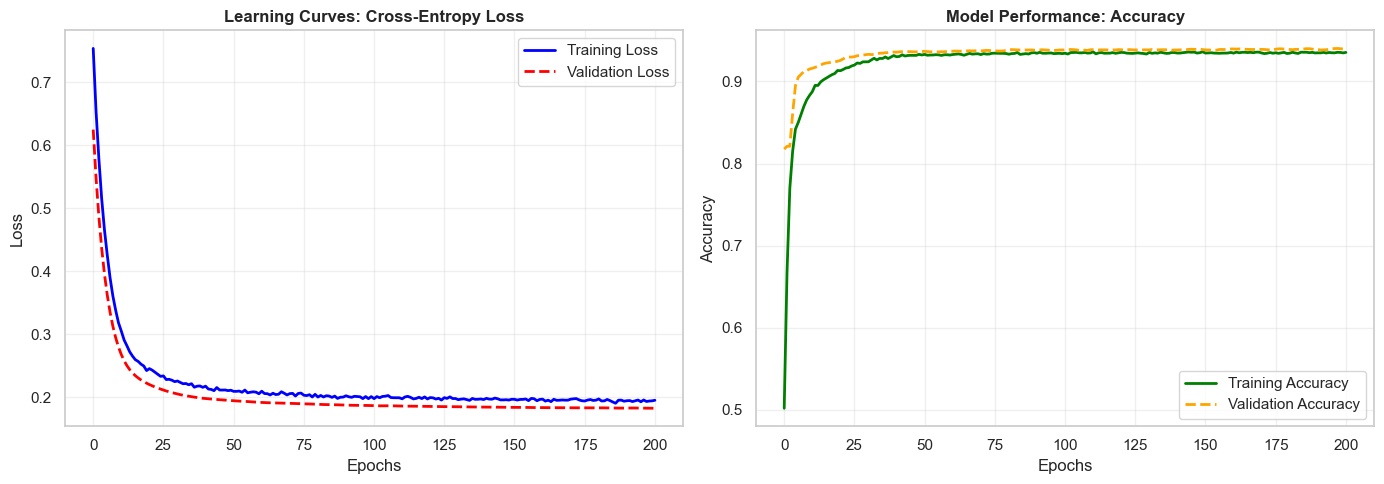


--- FINAL TEST SET RESULTS ---
              precision    recall  f1-score   support

   Human (0)       0.95      0.97      0.96      5194
     Bot (1)       0.87      0.77      0.82      1166

    accuracy                           0.94      6360
   macro avg       0.91      0.87      0.89      6360
weighted avg       0.94      0.94      0.94      6360



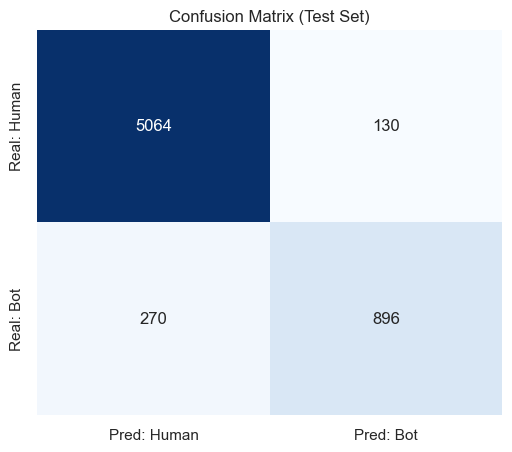

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- BLOQUE 10: EVALUACIÓN FINAL (Standard Training) ---

# 1. Recuperamos la mejor configuración del Tuning
best_conf = best_run['conf']
print(f"Retraining definitive model with: {best_conf}")

# 2. Instanciamos el modelo FINAL
final_model = BotGCN(num_features=4, 
                     hidden_channels=best_conf['hidden'], 
                     dropout_rate=best_conf['drop'])

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_conf['lr'])
criterion = torch.nn.CrossEntropyLoss()

# Listas para guardar el historial
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

# 3. ENTRENAMIENTO CON REGISTRO DE MÉTRICAS
print("Starting training loop...")
for epoch in range(201):
    # --- TRAIN ---
    final_model.train()
    optimizer.zero_grad()
    out = final_model(data_graph.x, data_graph.edge_index)
    loss = criterion(out[train_mask], data_graph.y[train_mask])
    loss.backward()
    optimizer.step()
    
    # --- VALIDATION (Solo para monitoreo) ---
    final_model.eval()
    with torch.no_grad():
        # Accuracy en Train
        pred_train = out.argmax(dim=1)
        acc_train = (pred_train[train_mask] == data_graph.y[train_mask]).sum().item() / train_mask.sum().item()
        
        # Loss y Accuracy en Validation
        out_val = final_model(data_graph.x, data_graph.edge_index)
        val_loss = criterion(out_val[val_mask], data_graph.y[val_mask])
        pred_val = out_val.argmax(dim=1)
        acc_val = (pred_val[val_mask] == data_graph.y[val_mask]).sum().item() / val_mask.sum().item()
    
    # Guardar en historial
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())
    history['train_acc'].append(acc_train)
    history['val_acc'].append(acc_val)

print("Training completed.")

# 4. GRÁFICAS DE APRENDIZAJE (EN INGLÉS)
epochs_range = range(len(history['train_loss']))
plt.figure(figsize=(14, 5))

# Gráfica 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
plt.title('Learning Curves: Cross-Entropy Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy', color='green', linewidth=2)
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title('Model Performance: Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. EVALUACIÓN FINAL EN TEST SET
final_model.eval()
with torch.no_grad():
    out_test = final_model(data_graph.x, data_graph.edge_index)
    pred_test = out_test.argmax(dim=1)
    
    y_true = data_graph.y[test_mask].cpu().numpy()
    y_pred = pred_test[test_mask].cpu().numpy()

print("\n--- FINAL TEST SET RESULTS ---")
print(classification_report(y_true, y_pred, target_names=['Human (0)', 'Bot (1)']))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Human', 'Pred: Bot'],
            yticklabels=['Real: Human', 'Real: Bot'])
plt.title('Confusion Matrix (Test Set)')
plt.show()

Initializing Weighted Model...
Starting Weighted Training loop...
Weighted Training completed.


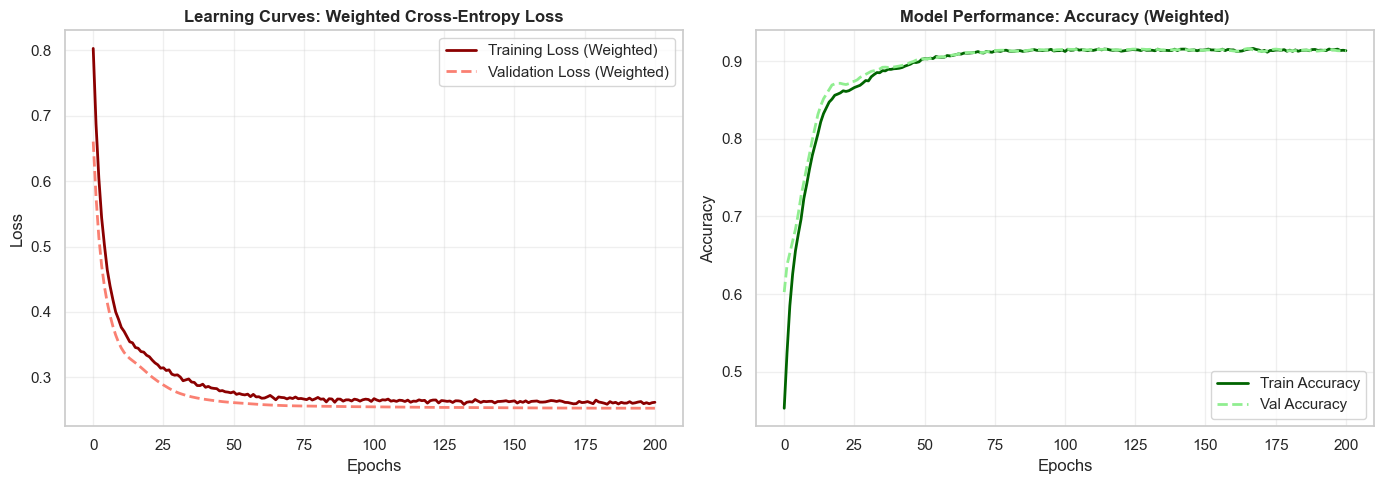


--- FINAL TEST SET RESULTS (WEIGHTED MODEL) ---
              precision    recall  f1-score   support

   Human (0)       0.97      0.92      0.95      5194
     Bot (1)       0.72      0.89      0.80      1166

    accuracy                           0.92      6360
   macro avg       0.85      0.91      0.87      6360
weighted avg       0.93      0.92      0.92      6360



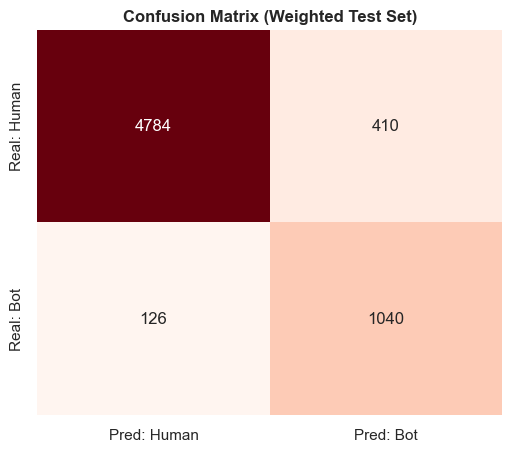

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch

# --- BLOQUE 13 (CORREGIDO): ENTRENAMIENTO BALANCEADO + MATRIZ DE CONFUSIÓN ---

# 1. CONFIGURACIÓN DEL MODELO CON PESOS
# Usamos la configuración ganadora: Hidden 64, Drop 0.6
print("Initializing Weighted Model...")
balanced_model_viz = BotGCN(num_features=4, hidden_channels=64, dropout_rate=0.6)
optimizer = torch.optim.Adam(balanced_model_viz.parameters(), lr=0.01, weight_decay=5e-4)

# IMPORTANTE: Aplicamos los pesos de clase calculados previamente
# Asegúrate de haber calculado 'class_weights' en el Bloque 11
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# 2. LISTAS PARA EL HISTORIAL
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

# 3. BUCLE DE ENTRENAMIENTO
print("Starting Weighted Training loop...")
for epoch in range(201): 
    # --- TRAINING PHASE ---
    balanced_model_viz.train()
    optimizer.zero_grad()
    out = balanced_model_viz(data_graph.x, data_graph.edge_index)
    loss = criterion(out[train_mask], data_graph.y[train_mask])
    loss.backward()
    optimizer.step()
    
    # --- VALIDATION PHASE (Solo registro) ---
    balanced_model_viz.eval()
    with torch.no_grad():
        # Accuracy Train
        pred_train = out.argmax(dim=1)
        acc_train = (pred_train[train_mask] == data_graph.y[train_mask]).sum().item() / train_mask.sum().item()
        
        # Loss & Accuracy Validation
        out_val = balanced_model_viz(data_graph.x, data_graph.edge_index)
        val_loss = criterion(out_val[val_mask], data_graph.y[val_mask])
        pred_val = out_val.argmax(dim=1)
        acc_val = (pred_val[val_mask] == data_graph.y[val_mask]).sum().item() / val_mask.sum().item()
    
    # Guardar métricas
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())
    history['train_acc'].append(acc_train)
    history['val_acc'].append(acc_val)

print("Weighted Training completed.")

# 4. GRÁFICAS DE APRENDIZAJE (EN INGLÉS)
epochs_range = range(len(history['train_loss']))
plt.figure(figsize=(14, 5))

# Gráfica A: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss (Weighted)', color='darkred', linewidth=2)
plt.plot(epochs_range, history['val_loss'], label='Validation Loss (Weighted)', color='salmon', linestyle='--', linewidth=2)
plt.title('Learning Curves: Weighted Cross-Entropy Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica B: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', color='darkgreen', linewidth=2)
plt.plot(epochs_range, history['val_acc'], label='Val Accuracy', color='lightgreen', linestyle='--', linewidth=2)
plt.title('Model Performance: Accuracy (Weighted)', fontsize=12, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. EVALUACIÓN FINAL EN TEST SET Y MATRIZ DE CONFUSIÓN
balanced_model_viz.eval()
with torch.no_grad():
    out_test = balanced_model_viz(data_graph.x, data_graph.edge_index)
    pred_test = out_test.argmax(dim=1)
    
    y_true = data_graph.y[test_mask].cpu().numpy()
    y_pred = pred_test[test_mask].cpu().numpy()

print("\n--- FINAL TEST SET RESULTS (WEIGHTED MODEL) ---")
print(classification_report(y_true, y_pred, target_names=['Human (0)', 'Bot (1)']))

# Matriz de Confusión (Usamos 'Reds' para diferenciarlo del modelo estándar)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Pred: Human', 'Pred: Bot'],
            yticklabels=['Real: Human', 'Real: Bot'])
plt.title('Confusion Matrix (Weighted Test Set)', fontsize=12, fontweight='bold')
plt.show()

In [19]:
import pandas as pd

# 1. IDENTIFICAR LOS NODOS "FALSOS POSITIVOS"
# Condición: La etiqueta real es 0 (Humano) PERO el modelo predijo 1 (Bot)
# Y debe ser del Test Set (test_mask)
fp_mask = (data_graph.y == 0) & (pred_test == 1) & (test_mask)
fp_node_ids = fp_mask.nonzero(as_tuple=False).flatten().tolist()

print(f"Total de Falsos Positivos encontrados: {len(fp_node_ids)}")
print("Mostrando análisis de 5 casos aleatorios...\n")

# 2. MAPEO ID -> USUARIO
# Necesitamos recuperar el nombre de usuario usando el DataFrame 'user_features' del Bloque 6
# Creamos un diccionario inverso: node_id -> authorUsername
id_to_username = dict(zip(user_features['node_id'], user_features['authorUsername']))

# 3. INSPECCIÓN VISUAL
for i, node_id in enumerate(fp_node_ids[:5]): # Solo los primeros 5
    username = id_to_username[node_id]
    
    # Recuperamos sus datos originales
    user_info = user_features[user_features['node_id'] == node_id].iloc[0]
    
    # Recuperamos UN ejemplo de texto original de este usuario
    # (Buscamos en el df original 'df')
    example_tweet = df[df['authorUsername'] == username]['clean_content'].iloc[0]
    
    print(f"--- CASO #{i+1}: {username} ---")
    print(f"📊 DATOS: Edad={user_info['account_age_days']} días | Entropía={user_info['intent_entropy']:.2f}")
    print(f"🏷️ ETIQUETAS: Heurística (Real)='Humano' -> GNN (Pred)='BOT'")
    print(f"💬 TEXTO: {example_tweet}")
    print("-" * 60)

Total de Falsos Positivos encontrados: 397
Mostrando análisis de 5 casos aleatorios...

--- CASO #1: 000_danilo3 ---
📊 DATOS: Edad=506 días | Entropía=1.22
🏷️ ETIQUETAS: Heurística (Real)='Humano' -> GNN (Pred)='BOT'
💬 TEXTO: @DanielNoboaOk Tiene el descaro de decir vota todo siete cuando no h hecho nada como q estuviera en su hacienda. La, respuesta del pueblo será aplastante, todo 5 https://t.co/8u9rFEFGEq
------------------------------------------------------------
--- CASO #2: 007Gonzalito ---
📊 DATOS: Edad=1172 días | Entropía=1.44
🏷️ ETIQUETAS: Heurística (Real)='Humano' -> GNN (Pred)='BOT'
💬 TEXTO: @LuisaGonzalezEc @MashiRafael https://t.co/8FMfLO9qzo
------------------------------------------------------------
--- CASO #3: 2020Fav ---
📊 DATOS: Edad=1088 días | Entropía=1.06
🏷️ ETIQUETAS: Heurística (Real)='Humano' -> GNN (Pred)='BOT'
💬 TEXTO: @LuisaGonzalezEc @DianaAtamaint @cnegobec Tanto les molesta que controlen ?
------------------------------------------------------------


In [21]:
import networkx as nx
import numpy as np

print("Preparando exportación a Gephi...")

# 1. OBTENER PREDICCIONES FINALES PARA TODO EL GRAFO
# Queremos visualizar CADA nodo con la decisión final de tu modelo balanceado
balanced_model.eval()
with torch.no_grad():
    out_all = balanced_model(data_graph.x, data_graph.edge_index)
    # Convertimos a array de numpy (0 = Humano, 1 = Bot)
    final_predictions = out_all.argmax(dim=1).cpu().numpy()
    
    # También obtenemos la probabilidad de ser Bot (para colorear por intensidad)
    # Aplicamos Softmax para tener probabilidad 0-1
    probs = out_all.softmax(dim=1)[:, 1].cpu().numpy()

# 2. CREAR EL GRAFO DE NETWORKX
G_export = nx.DiGraph() # Grafo Dirigido (A responde a B)

# --- AÑADIR NODOS CON ATRIBUTOS ---
# Iteramos sobre tu dataframe de usuarios (user_features)
print("Añadiendo nodos y atributos...")
for idx, row in user_features.iterrows():
    node_id_num = row['node_id']
    username = row['authorUsername']
    
    # Atributos que verás en Gephi:
    attrs = {
        'Account_Age': float(row['account_age_days']),
        'Entropy': float(row['intent_entropy']),
        'Heuristic_Score': float(row['heuristic_bot_score']),
        'GNN_Prediction': int(final_predictions[node_id_num]), # 0 o 1
        'Bot_Probability': float(probs[node_id_num]),          # 0.0 a 1.0
        'Label_Type': "Bot" if final_predictions[node_id_num] == 1 else "Humano"
    }
    
    G_export.add_node(username, **attrs)

# --- AÑADIR ARISTAS (CONEXIONES) ---
# Usamos el dataframe original de 'edges' (source -> target)
print("Añadiendo conexiones...")
# Filtramos solo aristas donde ambos nodos existen en nuestro set final
valid_users = set(user_features['authorUsername'])
valid_edges = edges[edges['source'].isin(valid_users) & edges['target'].isin(valid_users)]

for _, row in valid_edges.iterrows():
    G_export.add_edge(row['source'], row['target'])

# 3. GUARDAR ARCHIVO
filename = "tesis_bot_detection.gexf"
nx.write_gexf(G_export, filename)

print(f"✅ ¡Éxito! Archivo '{filename}' generado.")
print(f"Estadísticas del Grafo: {G_export.number_of_nodes()} nodos, {G_export.number_of_edges()} conexiones.")

Preparando exportación a Gephi...
Añadiendo nodos y atributos...
Añadiendo conexiones...
✅ ¡Éxito! Archivo 'tesis_bot_detection.gexf' generado.
Estadísticas del Grafo: 42075 nodos, 64161 conexiones.
